# Finding Lane Lines on the Road

This is a project to find lane lines on the road with python and opencv. The agenda is to first develop a pipeline which will annotate the lane lines on an image and later extend the technique to find lane line on video streams. This project explores many opencv functions to do image processing togather with numpy to accomplish the task.

***

## Ideas for Lane Detection Pipeline

**Some OpenCV functions that are used in this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image


## Import Packages

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import random

%matplotlib inline

## Load All Images

These are my test images, some of them are given in the original project and others were screenshots taken from the video. I have created a function to show all the images at once, the function also saves the combined image with the given name.

In [3]:
import os

images = []
for i in os.listdir("test_images/"):
    images.append(mpimg.imread('test_images/' + i))

# show_all_images(images, 'all_images.jpg')

## Helper Functions

Below are some helper functions.

In [4]:
import math

def get_slope(line):
    """Finds slope of the given line"""
    # take the first element in the array
    line = line[0]
    x1 = line[0]
    y1 = line[1]
    x2 = line[2]
    y2 = line[3]
    slope = (y2-y1)/(x2-x1)
    return slope

def get_slope_length_and_intercept(line):
    """Finds slope, length and intercept of the given line"""
    x1 = line[0]
    y1 = line[1]
    x2 = line[2]
    y2 = line[3]
    slope = (y2-y1)/(x2-x1)
    length = np.sqrt((y2-y1)**2 + (x2-x1)**2)
    intercept = y1 - slope*x1
    return slope, length, intercept

def get_line_points(line, y1, y2):
    """
    Given line and top and bottm points, this function extents that line 
    to the y1, y2 and returns this longer line
    """
    if line is None:
        return None
    
    slope, length, intercept = get_slope_length_and_intercept(line)
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    
    return [x1, y1, x2, y2]

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
#         print(line)
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), [random.randint(0,255), random.randint(0,255), random.randint(0,255)], thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    if lines is None:
        print('no lines detected')
        print(img.shape)
        plt.imshow(img)
        plt.show()
        return None
    img_black = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(img_black, lines)
    return img_black, lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.95, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)
    
def select_region(image):
    """
    Selects a region of interest
    """
    rows, cols = image.shape[:2]
    bottom_left  = [cols*0.1, rows*0.94]
    top_left     = [cols*0.4, rows*0.6]
    bottom_right = [cols*0.9, rows*0.94]
    top_right    = [cols*0.6, rows*0.6] 
    # the vertices are an array of polygons (i.e array of arrays) and the data type must be integer
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return region_of_interest(image, vertices)

def draw_line(img, line, color = (255,0,0), thickness=16):
    """
    Draws a line connecting the given points with 
    the given color and thickness
    """
    if(line is not None):
        line = get_line_points(line, img.shape[0], int(img.shape[0]* 0.63))
        cv2.line(img,(line[0], line[1]),(line[2],line[3]), color, thickness)

def show_all_images(images, filename):
    """
    Show all images at once, also writes to a file with specified filename
    """
    fig = plt.figure(figsize=(16, 32))
    for i, image in enumerate(images):
        plt.axis('off')
        plt.subplot(5, 2, i+1)
        plt.imshow(images[i], cmap='gray')
    plt.savefig(filename)

def hsl(image):
    """Convert the given image to HLS color space"""
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

def hsv(image):
    """Convert the given image to HSV color space"""
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)


## Color Selection

To isolate lane lines from other parts of the image we use the fact that lane lines are either white or yellow in color.  With that ides we can employ color selection technique which can isolate particular range of colors from an image. Here we use different color spaces to properly identify and seperate the lane lines on the road. First we use color selection in RGB image later we do the same with HSL image by converting the rgb image to hsl with opencv cvtColor() function. Then we compare the results and choose either or a combination of the methods in our actual process.

#### RGB Color space

First i used the RGB color space to identify the lane lines based on R, G and B values. 

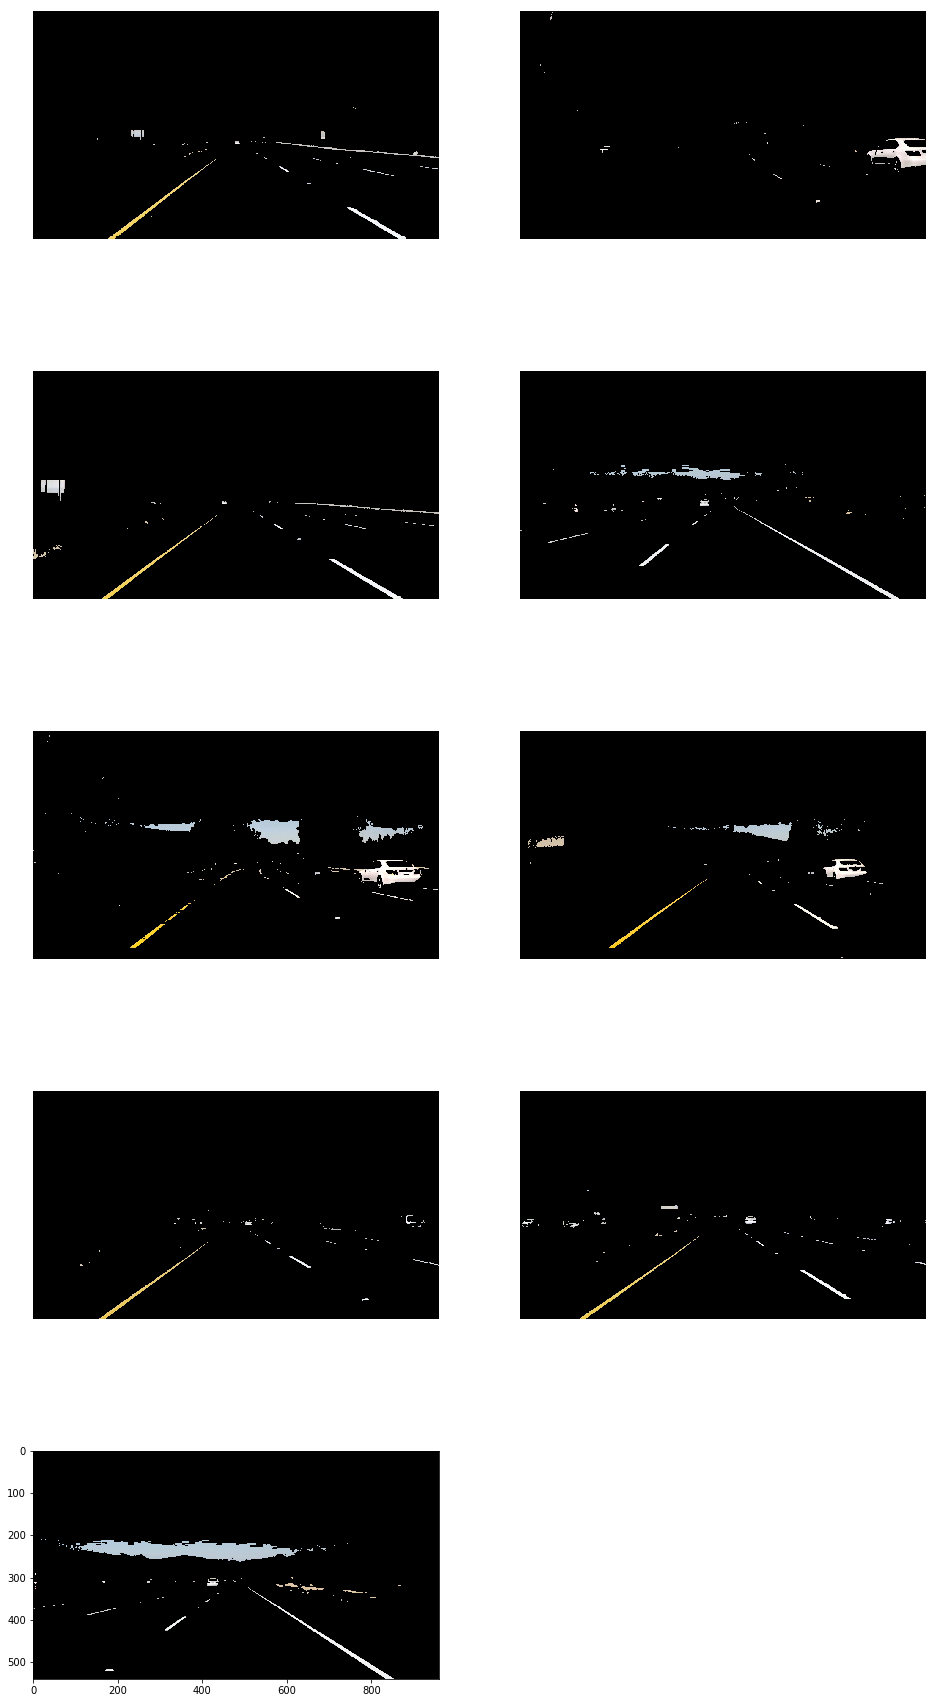

In [5]:
def rgb_color_select(image):
    """
    Seperate white and yellow color regions from
    the given image based on RGB values
    """
    # creating white mask
    lower_range = np.uint8([180,180,180])
    upper_range = np.uint8([255,255,255])
    white_image = cv2.inRange(image, lower_range, upper_range)
    
    #creating yellow mask
    lower_range = np.uint8([190, 190, 0])
    upper_range = np.uint8([255,255,255])
    yellow_image = cv2.inRange(image, lower_range, upper_range)
    
    #combine both the masks
    mask = cv2.bitwise_or(white_image, yellow_image)
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    
    return masked_image

rgb_color_selected = list(map(rgb_color_select, images))
show_all_images(rgb_color_selected, 'rgb_select.jpg')

*** The the above image shows the regions which got selected. We can compare this with color selection with other color spaces ***

#### HSL Color space
Next i tried HSL color space where color is denoted by hue, saturation and lightness values.

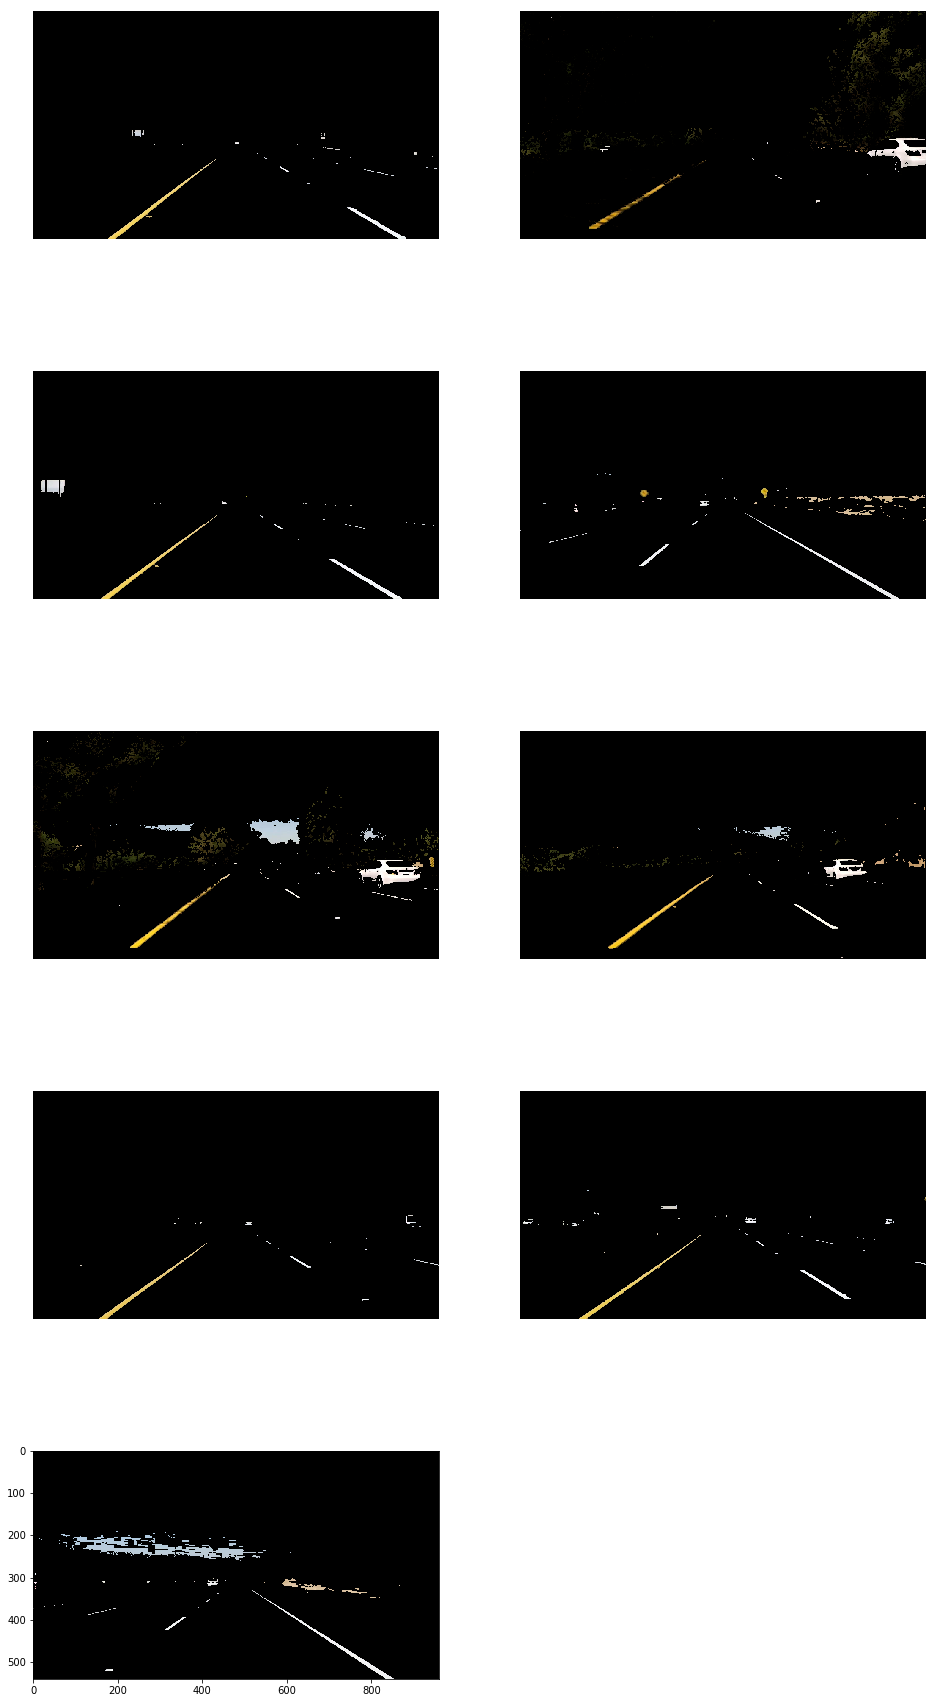

In [6]:
def hsl_color_select(image):
    """
    Seperate white and yellow color regions from
    the given image based on HSL values
    """
    img = hsl(image)
    # creating white mask
    lower_range = np.uint8([  0, 200,   0])
    upper_range = np.uint8([255,255,255])
    white_image = cv2.inRange(img, lower_range, upper_range)
    
    #creating yellow mask
    lower_range = np.uint8([10, 0, 100])
    upper_range = np.uint8([40, 255, 255])
    yellow_image = cv2.inRange(img, lower_range, upper_range)
    
    #combine both the masks
    mask = cv2.bitwise_or(white_image, yellow_image)
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    
    return masked_image

hsl_color_selected = list(map(hsl_color_select, images))
show_all_images(hsl_color_selected, 'hsl_select.jpg')


*** Color selection in HSL color space could identify yellow regions in the image properly whereas color selection in the RGB color space was little better in identifying lane lines which are white in color. Now i combined both RGB and HSL color selection to create a better lane detection ***

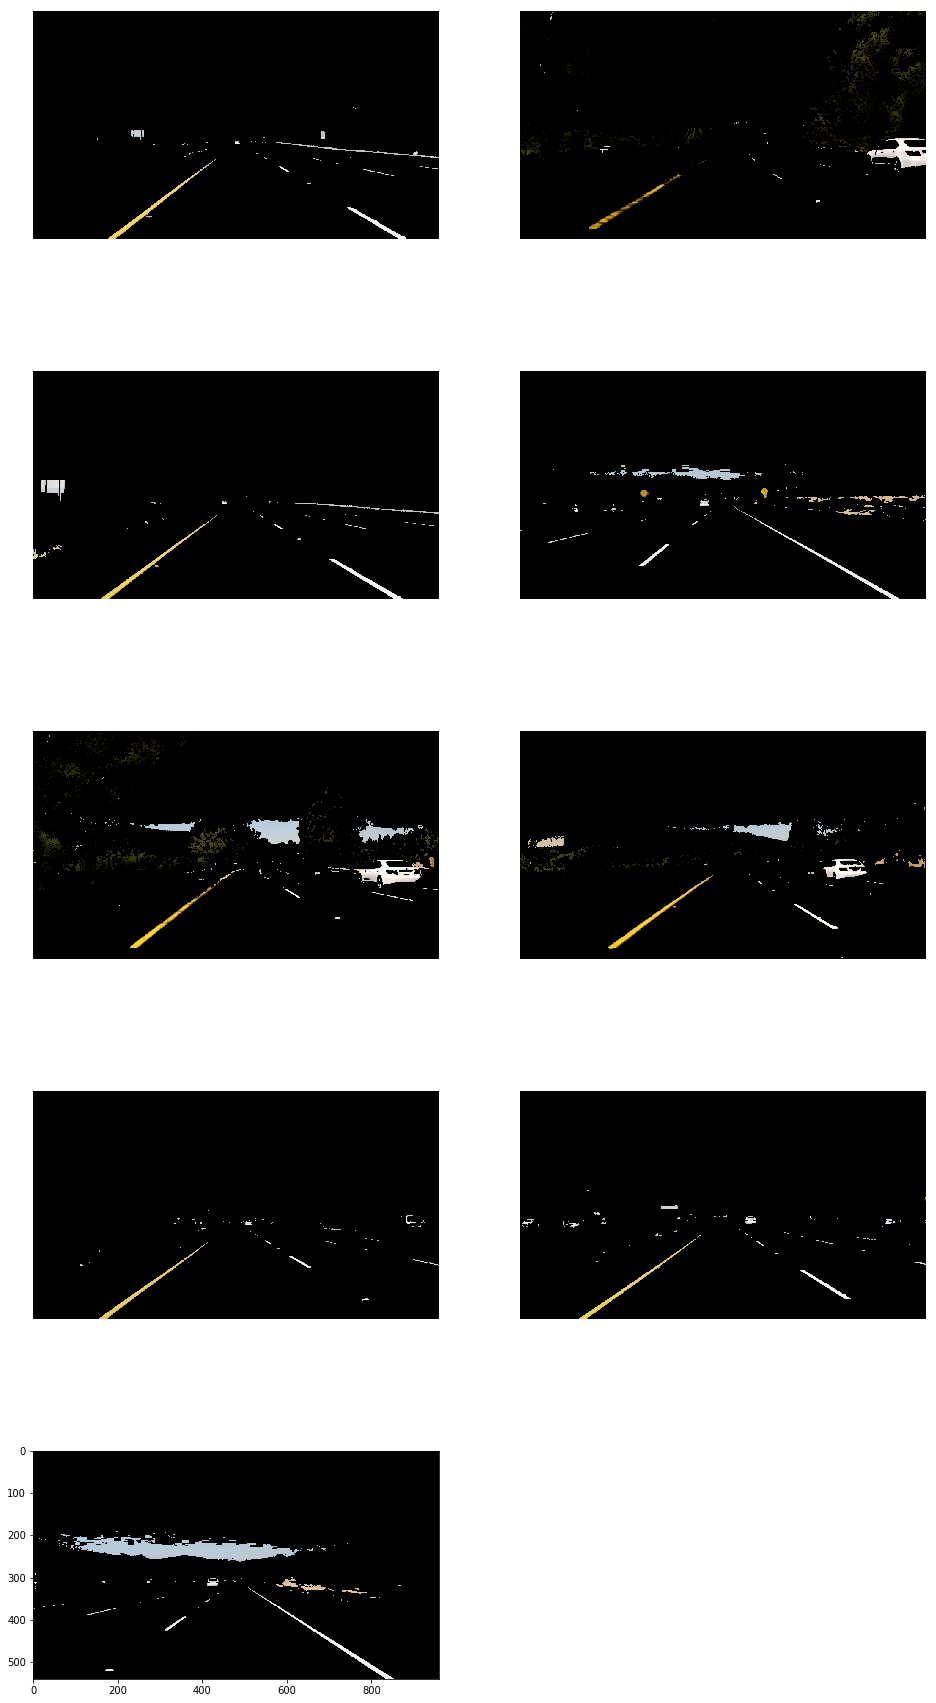

In [7]:
def color_select(image):
    # creating white mask
    lower_range = np.uint8([180,180,180])
    upper_range = np.uint8([255,255,255])
    white_image = cv2.inRange(image, lower_range, upper_range)
    
    #creating yellow mask
    lower_range = np.uint8([190, 190, 0])
    upper_range = np.uint8([255,255,255])
    yellow_image = cv2.inRange(image, lower_range, upper_range)
    
    #combine both the masks
    rgb_mask = cv2.bitwise_or(white_image, yellow_image)
    
    hsl_img = hsl(image)
    # creating white mask
    lower_range = np.uint8([  0, 200,   0])
    upper_range = np.uint8([255,255,255])
    white_image = cv2.inRange(hsl_img, lower_range, upper_range)
    
    #creating yellow mask
    lower_range = np.uint8([10, 0, 100])
    upper_range = np.uint8([40, 255, 255])
    yellow_image = cv2.inRange(hsl_img, lower_range, upper_range)
    
    #combine both the masks
    hsl_mask = cv2.bitwise_or(white_image, yellow_image)
    
    mask = cv2.bitwise_or(rgb_mask, hsl_mask)
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    
    return masked_image

color_selected = list(map(color_select, images))
show_all_images(color_selected, 'color_select.jpg')

## Gaussian Bluring
Now i apply a bluring filter on the image to smooth it. I am using a kernal size of 15 to get a fair amount of smoothing.

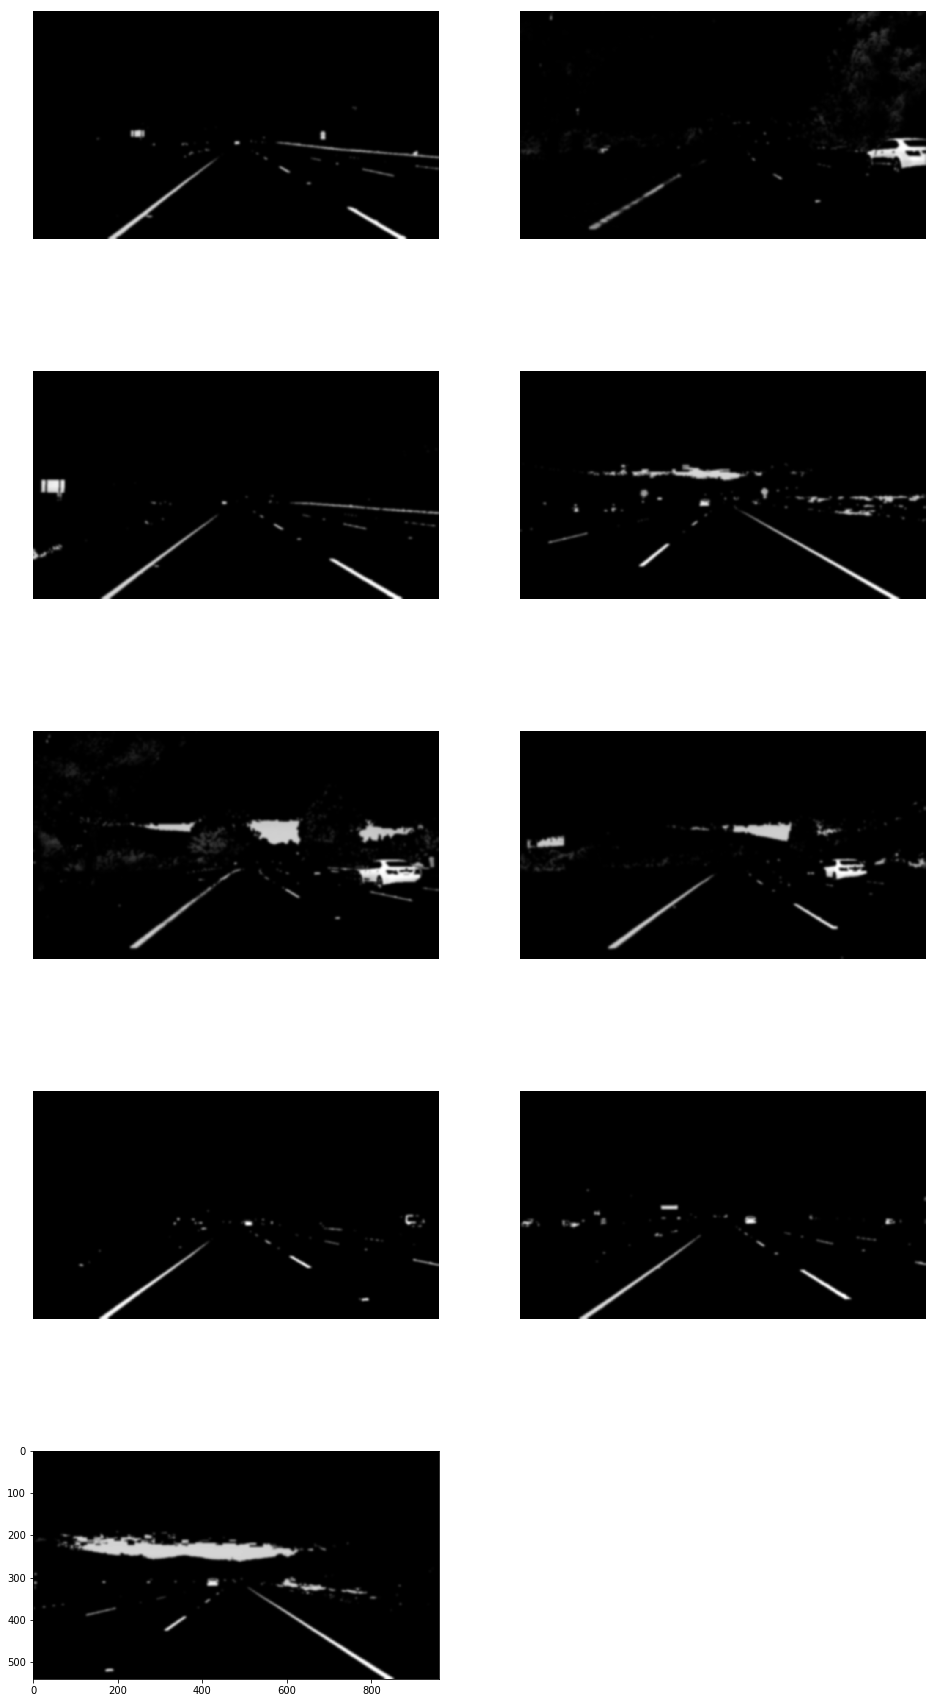

In [8]:
def apply_blur(img):
    gray = grayscale(img)
    blured = gaussian_blur(gray, kernel_size=15)
    return blured

blur = list(map(apply_blur, color_selected))
show_all_images(blur, 'blur.jpg')

## Canny edge detection
Next i applied canny edge detection algorithm to find the edges. This algorithm finds the image gradient in both x and y direction and later thins the gradient lines to a single pixel line. This is a standerd way of identifying edges in images.

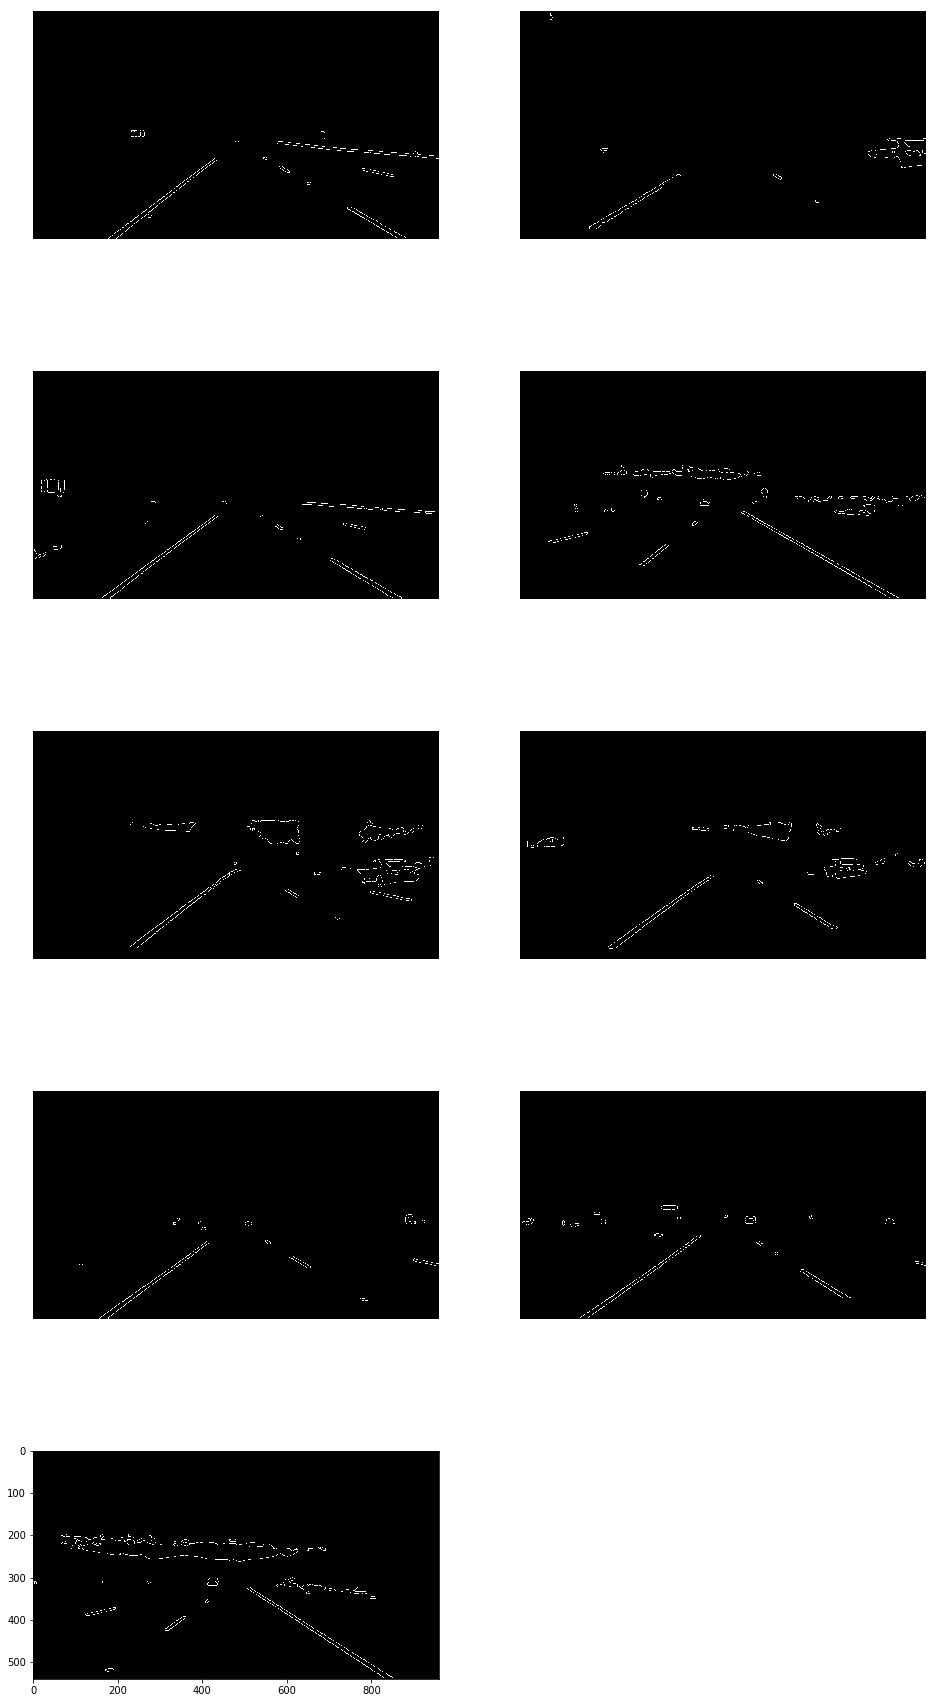

In [9]:
def apply_canny(img):
     return canny(img, low_threshold=50, high_threshold=150)

edge = list(map(apply_canny, blur))
show_all_images(edge, 'edge.jpg')

## Region of interest
If we look at our test images we can find that lane lines comes in the region covered by a triangle from the bottom of the image. We can use this induction to limit our search for lane lines to just this region thus simplifying our process.

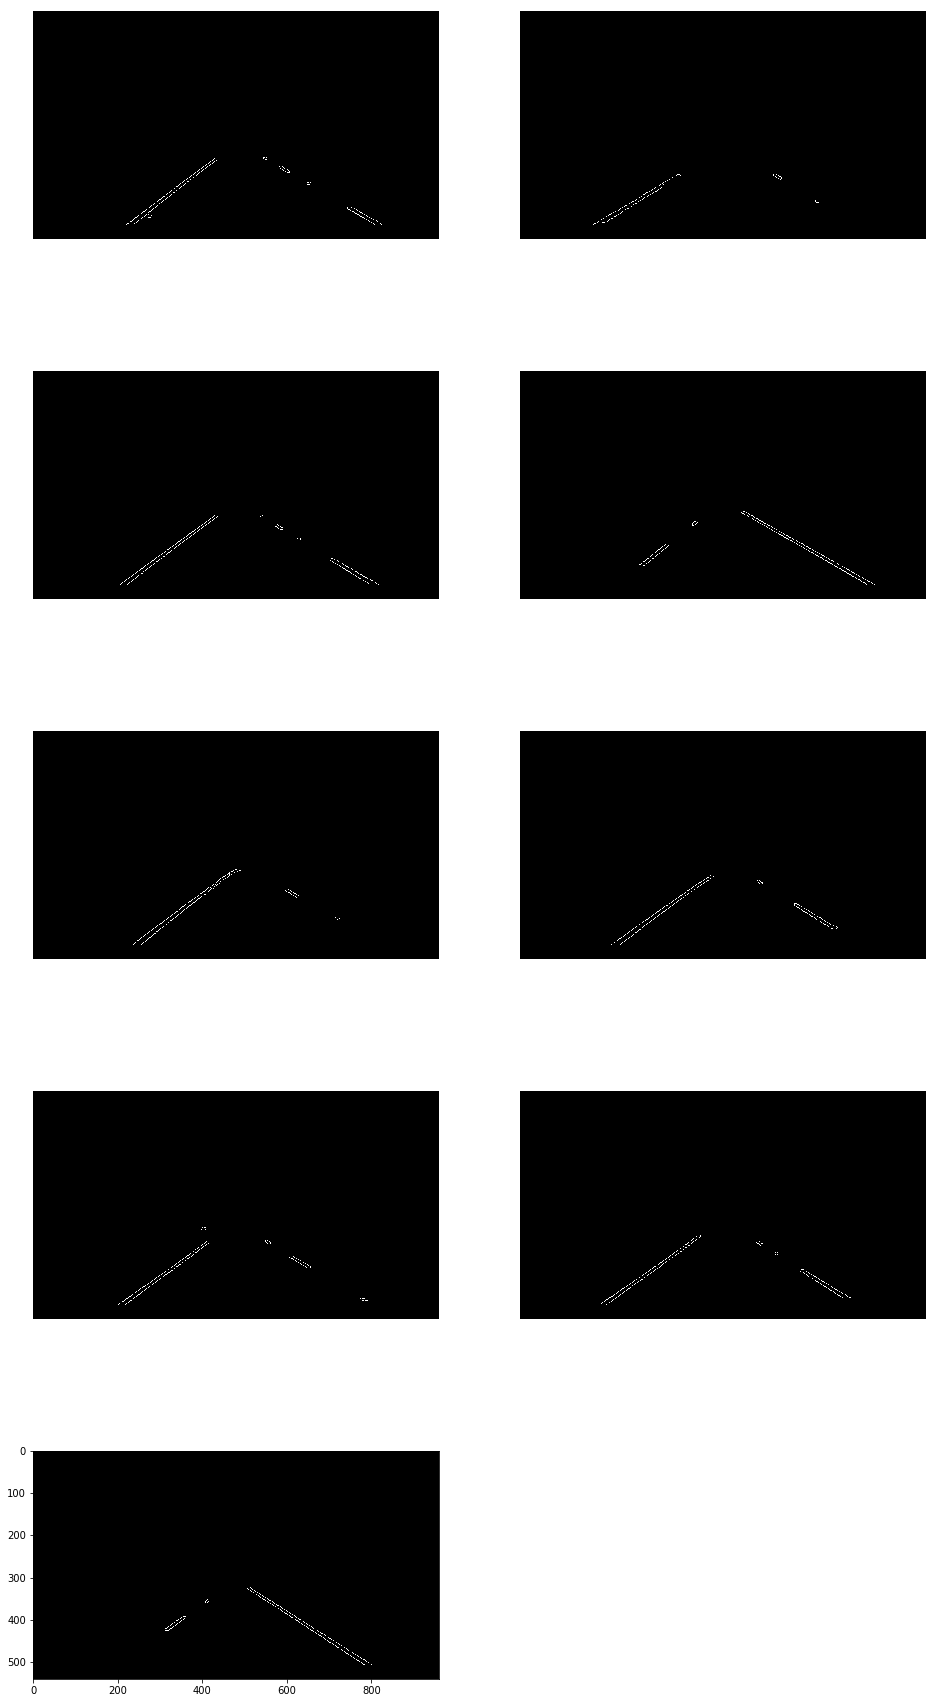

In [10]:
roi = list(map(select_region, edge))
show_all_images(roi, 'roi.jpg')

## Hough lines
Now we identify lines in the images using hough lines. This algorithm maps the result of canny edge detection to a space called hough space. In this space points will becomes lines and intersection of lines means that there is a straight line. Many lines get identified in the image. I use a pythons random function to generate random colors for each line.

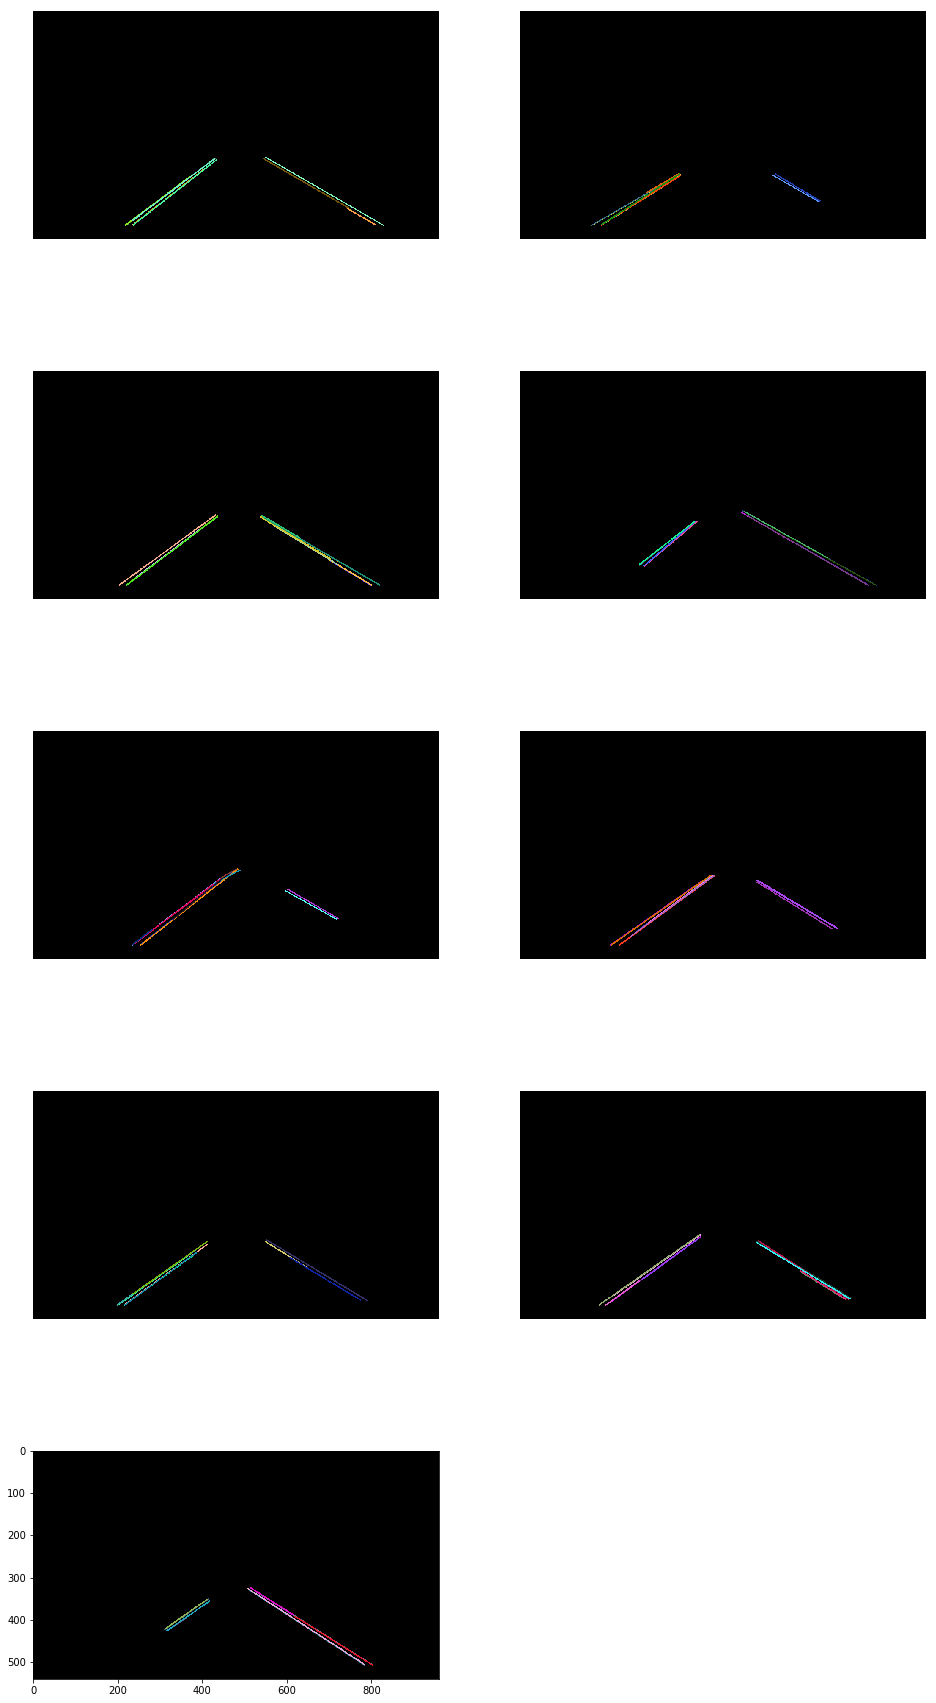

In [11]:
def apply_hough(img):
    image, lines = hough_lines(img, 1, np.pi/180, 20, 20, 300)
#     print(lines)
    if lines is None:
        print('none error')
    return image
        
hough = list(map(apply_hough, roi))
show_all_images(hough, 'hough.jpg')

## Combining images
Now i overlay these lines on our test images

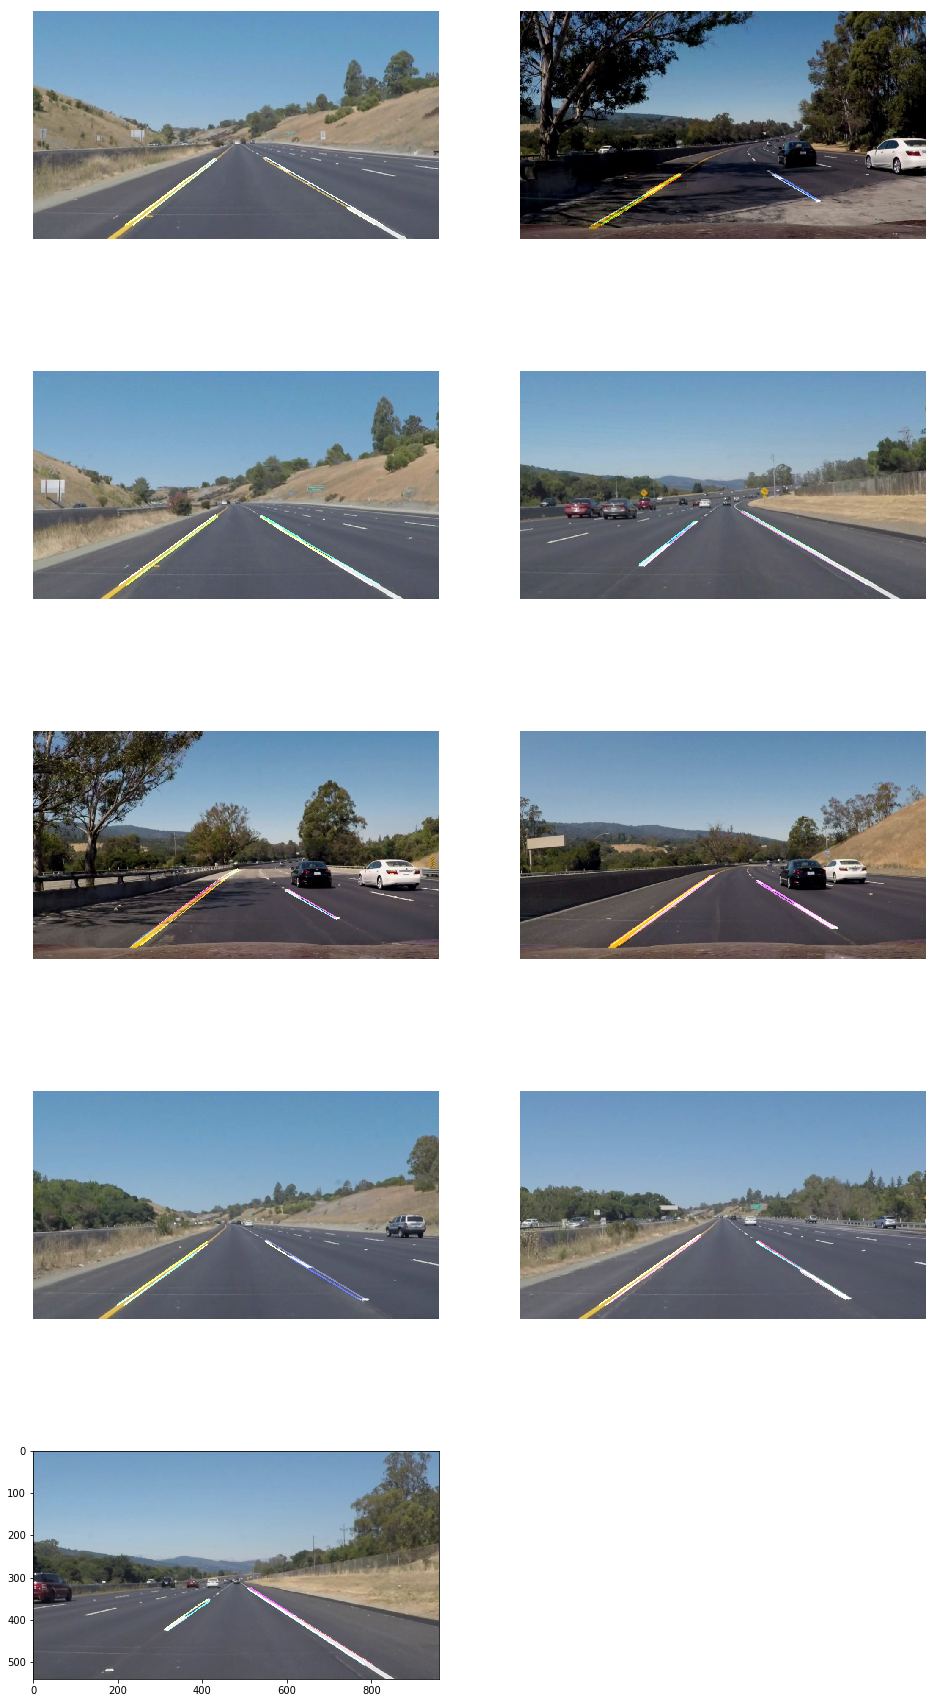

In [12]:
combined = []
for i, overlay in list(zip(images, hough)):
    combined.append(weighted_img(overlay, i))
show_all_images(combined, 'overlay.jpg')


## Averaging the lines

Hough line detection gives you a set of lines. We need a single line of the left as well as on the right. We do this by the fact that the lines on the left will have a negative slope and those on the right have positive slope. We group lines by their slope and finally average them so get a single line on the left as well as on the right.

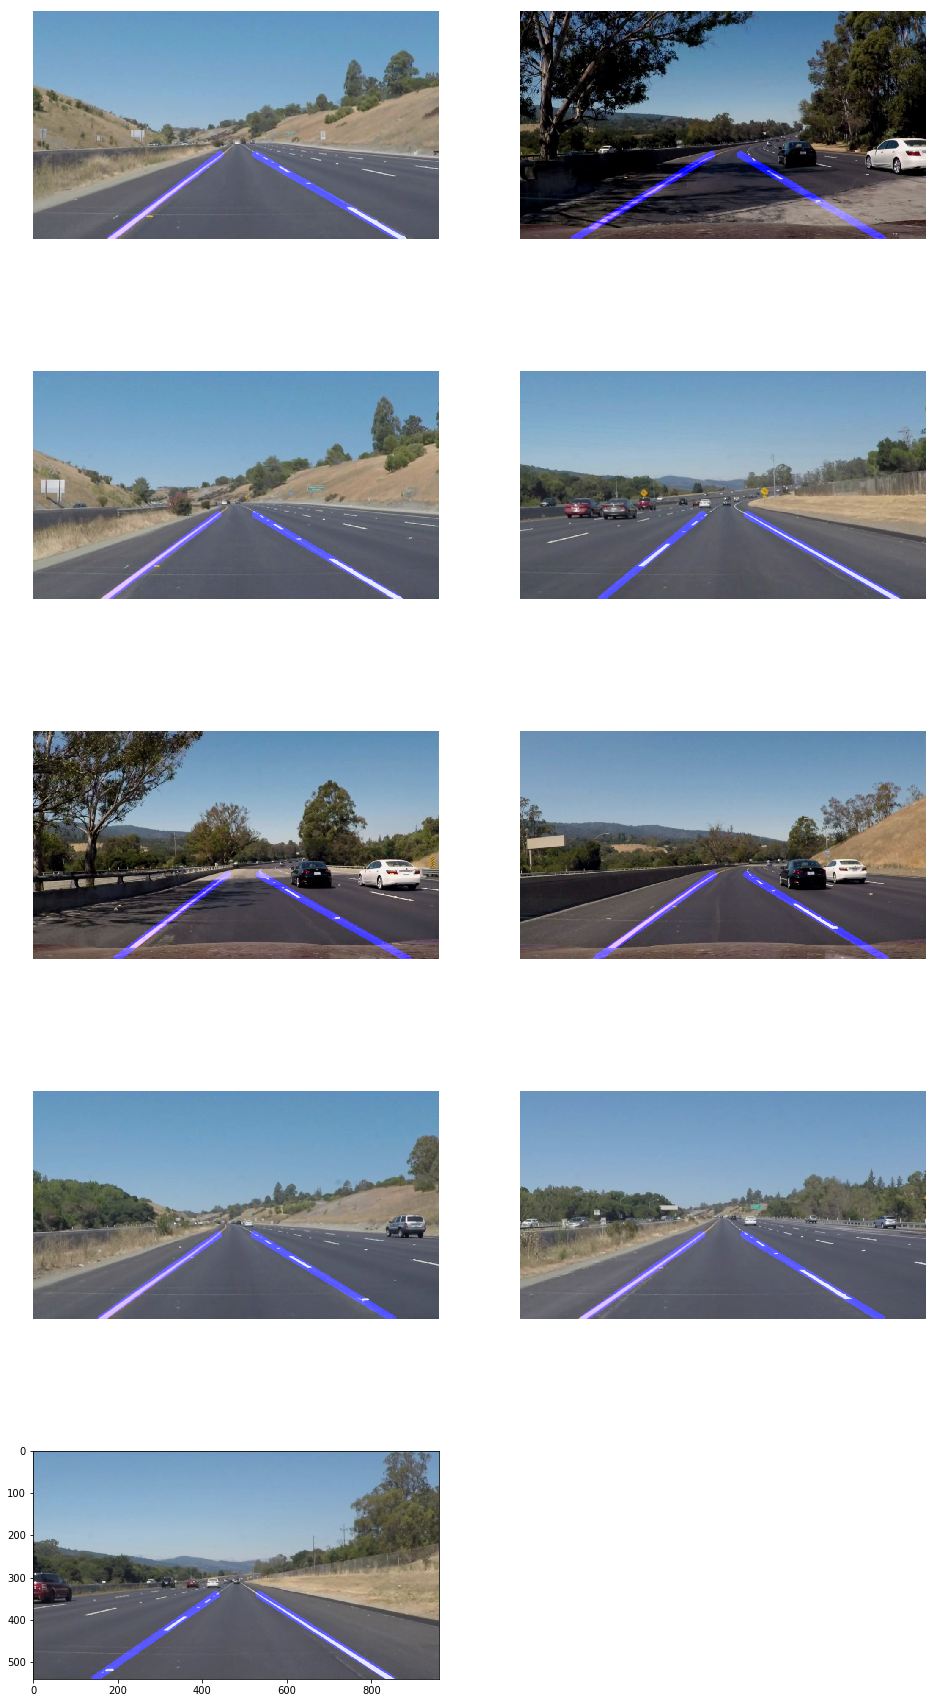

In [13]:
def get_lanes(hough_lines):
    """
    Given hough lines this function will identify lines on the left and right,
    group and average them to output single line on left and right
    """
    left_lines = []
    right_lines = []
    
    for line in hough_lines:
        slope = get_slope(line)
        if slope > 0:
            left_lines.append(line[0])
        else:
            right_lines.append(line[0])

    line_right = np.int32(np.average(right_lines, axis=0))
    line_left = np.int32(np.average(left_lines, axis=0))
    return line_right, line_left

def draw_lane_lines(image):
    """This is the pipeline function where we do all the steps involved one by one"""
#     img = np.copy(image)
    rgb_masked = color_select(image)
    gray = grayscale(rgb_masked)
    blured = gaussian_blur(gray, kernel_size=15)
    edge = canny(blured, low_threshold=50, high_threshold=150)
    roi = select_region(edge)
    line_img, lines = hough_lines(roi, 1, np.pi/180, 20, 20, 300)
    line_right, line_left = get_lanes(lines)
    
    black_img = line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    
    # Draw lines
    draw_line(black_img, line_left, color=(255, 0, 0), thickness=15)
    draw_line(black_img, line_right, color=(255, 0, 0), thickness=15)
    
    final_image = weighted_img(black_img, image)
    return final_image

l = list(map(draw_lane_lines, images))
show_all_images(l, 'lane_drawn.jpg')

## Test on Videos

As we have succesfully tested our pipeline on all our test images, lets extent our program to do the same with video streams. Video streams are just images shown at an itervel called frame rate. Ususlly the frame rate is 24 frame per second. Which means at every second of the video there will be 24 images. We use Moviepy library to edit our test videos.
We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [15]:
from collections import deque

QUEUE_SIZE=62

class LaneProcessor:
    def __init__(self):
        self.left_lines  = deque(maxlen=QUEUE_SIZE)
        self.right_lines = deque(maxlen=QUEUE_SIZE)

    def process_image(self, image):
        rgb_masked = color_select(image)
        gray = grayscale(rgb_masked)
        blured = gaussian_blur(gray, kernel_size=15)
        edge = canny(blured, low_threshold=50, high_threshold=150)
        roi = select_region(edge)
        line_img, lines = hough_lines(roi, 1, np.pi/180, 20, 20, 300)
        
        if lines is None:
            return image
        line_right, line_left = get_lanes(lines)

        def mean_lines(line, lines):
#             print(line)
            if line is not None:
                lines.append(line)

            if len(lines)>0:
                line = np.mean(lines, axis=0, dtype=np.int32)
            return line

        line_left  = mean_lines(line_left,  self.left_lines)
        line_right = mean_lines(line_right, self.right_lines)
        
        blank_image = np.zeros_like(image)
        
        draw_line(blank_image, line_left)
        draw_line(blank_image, line_right)
        i = weighted_img(blank_image, image)

        return i
    
#         return image

In [16]:
def process_video(video_input, video_output):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    detector = LaneProcessor()

    clip = VideoFileClip(os.path.join('test_videos', video_input))
    processed = clip.fl_image(detector.process_image)
    processed.write_videofile(os.path.join('test_videos_output', video_output), audio=False)

Let's try the one with the solid white lane on the right first ...

In [17]:
%time process_video('solidWhiteRight.mp4', 'solidWhiteRight.mp4')

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:10<00:00, 21.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 12.1 s, sys: 304 ms, total: 12.4 s
Wall time: 11.3 s


## Build a Lane Finding Pipeline



The following is the output of running our lane finding pipeline on the given video streams.

In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('test_videos_output/solidWhiteRight.mp4'))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [19]:
%time process_video('solidYellowLeft.mp4', 'solidYellowLeft.mp4')

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:28<00:00, 23.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 35.9 s, sys: 804 ms, total: 36.7 s
Wall time: 29.6 s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('test_videos_output/solidYellowLeft.mp4'))

## Challenge

The challenge video given with the test samples is quite challenging due to the shadows and lighting variations. Now lets test our pipeline on this video.

In [21]:
%time process_video('challenge.mp4', 'challenge.mp4')

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:18<00:00, 13.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 19.4 s, sys: 504 ms, total: 19.9 s
Wall time: 20.8 s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('test_videos_output/challenge.mp4'))